<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Cross_Resonance_Gate_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

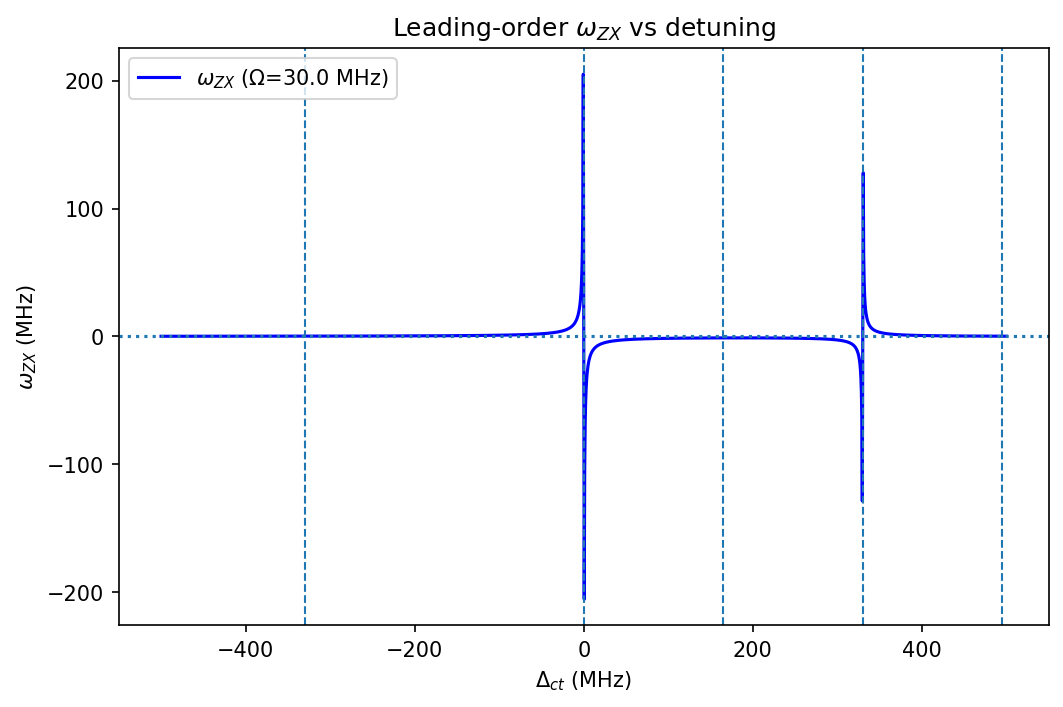

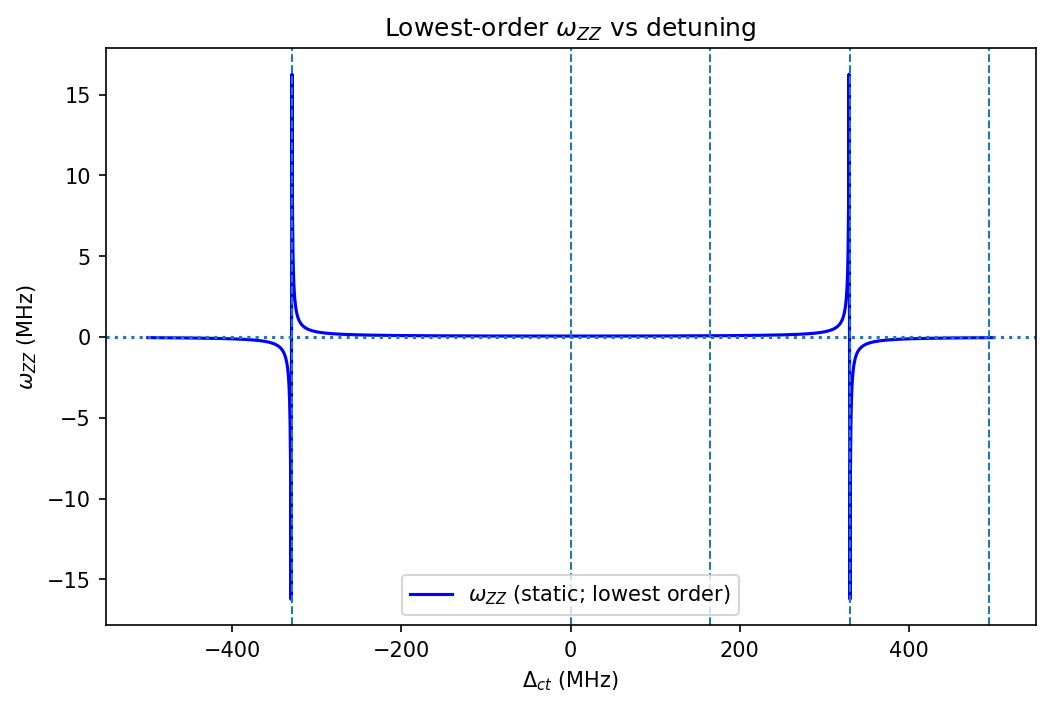

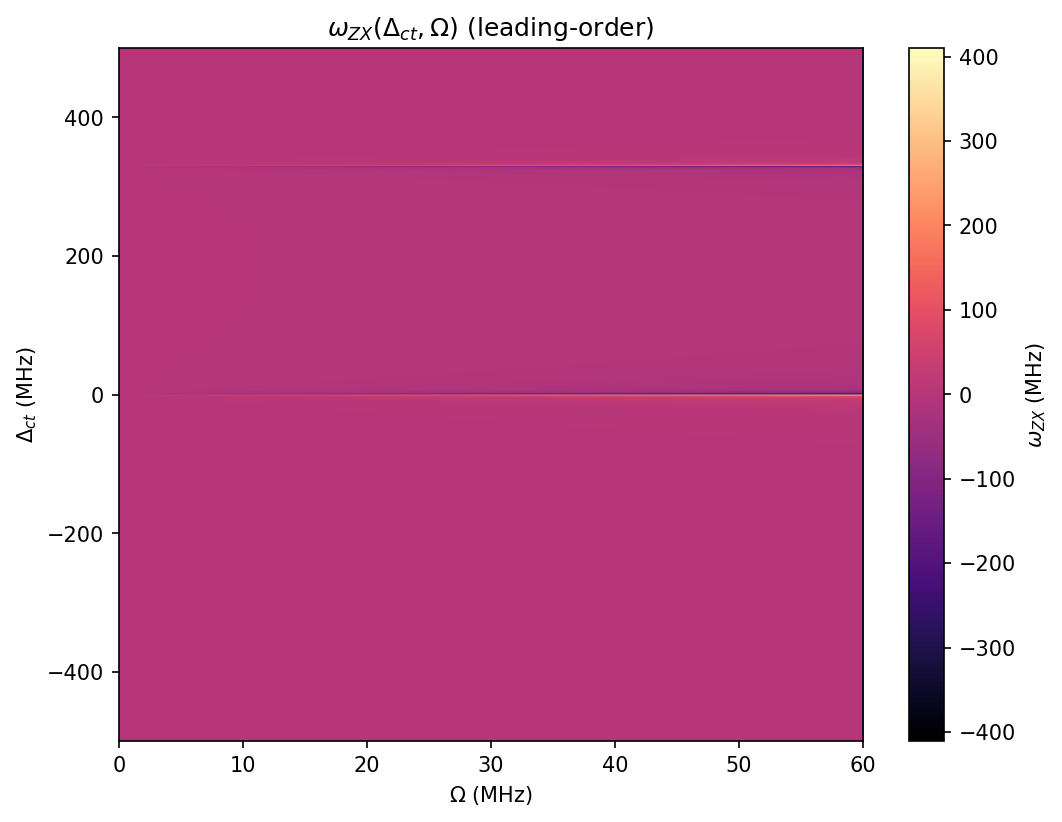

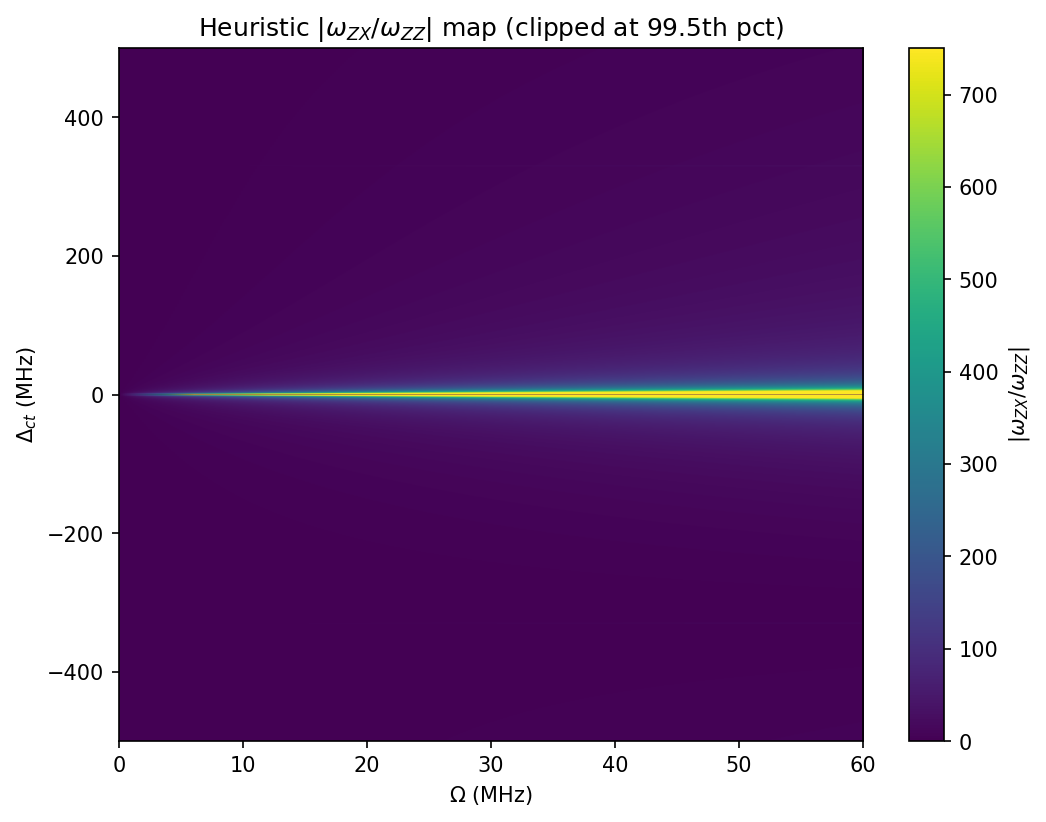

In [ ]:
#@title Cross-Resonance (CR) gate — slices & heatmaps (PRA 2020 formulas)
# PEP 8/257; no seaborn; one chart per figure.

from __future__ import annotations
from dataclasses import dataclass
from typing import Tuple
import math
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Control knobs (MHz)
# -----------------------------
@dataclass
class CRKnobs:
    f_c: float = 5114.0        # control frequency
    f_t: float = 4914.0        # target frequency
    alpha_c: float = -330.0    # control anharmonicity (negative)
    alpha_t: float = -330.0    # target anharmonicity
    J: float = 3.8             # exchange coupling
    Omega0: float = 30.0       # default drive for Δ-slices
    use_energy_basis: bool = False  # toggle ν-corrections (~10–15%)

    # Sweep grids
    delta_span: Tuple[float, float] = (-500.0, 500.0)
    delta_points: int = 1801
    omega_span: Tuple[float, float] = (0.0, 60.0)
    omega_points: int = 361

K = CRKnobs()

# -----------------------------
# Helpers & ν-coefficients
# -----------------------------
def _safe_div(a: float, b: float, eps: float = 1e-12) -> float:
    """Return a/b with a small guard to avoid blow-ups at poles."""
    if abs(b) < eps:
        return np.sign(b) * 1e12
    return a / b

def _epsilon_from_alpha_over_omega(alpha_mhz: float, omega_mhz: float) -> float:
    """Solve ε from (9 − 4r) ε² + 16(1 − r) ε + 64 r = 0, with r = α/ω."""
    r = alpha_mhz / omega_mhz
    A = (9.0 - 4.0 * r)
    B = 16.0 * (1.0 - r)
    C = 64.0 * r
    disc = max(B * B - 4.0 * A * C, 0.0)
    if abs(A) < 1e-15:
        return 0.2
    e1 = (-B + math.sqrt(disc)) / (2.0 * A)
    e2 = (-B - math.sqrt(disc)) / (2.0 * A)
    roots = [e for e in (e1, e2) if e > 0.0 and np.isfinite(e)]
    return min(roots) if roots else 0.2

def _nu_energy_basis(alpha_mhz: float, omega_mhz: float) -> Tuple[float, float]:
    """Energy-basis ν_01, ν_12 up to O(ε²)."""
    eps = _epsilon_from_alpha_over_omega(alpha_mhz, omega_mhz)
    nu01 = 1.0 - (1.0 / 8.0) * eps - (11.0 / 256.0) * (eps ** 2)
    nu12 = (1.0 - 0.25 * eps - (73.0 / 512.0) * (eps ** 2)) / math.sqrt(2.0)
    return nu01, nu12

def _nu_kerr() -> Tuple[float, float]:
    """Kerr-limit charge matrix elements."""
    return 1.0, 1.0 / math.sqrt(2.0)

if K.use_energy_basis:
    nu_c01, nu_c12 = _nu_energy_basis(K.alpha_c, K.f_c)
    nu_t01, nu_t12 = _nu_energy_basis(K.alpha_t, K.f_t)
else:
    nu_c01, nu_c12 = _nu_kerr()
    nu_t01, nu_t12 = _nu_kerr()

# -----------------------------
# Leading-order rates (MHz)
# -----------------------------
def omega_zx_mhz(delta_ct: float, J: float, Omega: float, alpha_c: float) -> float:
    r"""Entangling rate ω_ZX ≈ JΩ[(Δ+α_c)^{-1} − Δ^{-1}] with small ν-correction."""
    kerr = J * Omega * (_safe_div(1.0, delta_ct + alpha_c) - _safe_div(1.0, delta_ct))
    eb = 0.5 * J * Omega * nu_t01 * (
        (nu_c12 ** 2) * _safe_div(1.0, delta_ct + alpha_c) - 2.0 * (nu_c01 ** 2) * _safe_div(1.0, delta_ct)
    )
    return 0.5 * (kerr + eb)

def omega_zz_mhz(delta_ct: float, J: float, alpha_c: float, alpha_t: float) -> float:
    r"""Static ZZ ≈ J²[(Δ−α_t)^{-1} − (Δ+α_c)^{-1}] with small ν-correction."""
    kerr = (J ** 2) * (_safe_div(1.0, delta_ct - alpha_t) - _safe_div(1.0, delta_ct + alpha_c))
    eb = 0.5 * (J ** 2) * (
        (nu_c01 ** 2) * (nu_t12 ** 2) * _safe_div(1.0, delta_ct - alpha_t) -
        (nu_t01 ** 2) * (nu_c12 ** 2) * _safe_div(1.0, delta_ct + alpha_c)
    )
    return 0.5 * (kerr + eb)

# Region boundaries (poles) for I–V:
REGION_LINES = (K.alpha_t, 0.0, -K.alpha_c / 2.0, -K.alpha_c, -1.5 * K.alpha_c)
def _annotate_regions(ax):
    for x in REGION_LINES:
        ax.axvline(x, linestyle="--", linewidth=1.0)

# -----------------------------
# Slices
# -----------------------------
DELTA = np.linspace(K.delta_span[0], K.delta_span[1], K.delta_points)
OMEGA = np.linspace(K.omega_span[0], K.omega_span[1], K.omega_points)

wzx_slice = np.array([omega_zx_mhz(d, K.J, K.Omega0, K.alpha_c) for d in DELTA])
wzz_slice = np.array([omega_zz_mhz(d, K.J, K.alpha_c, K.alpha_t) for d in DELTA])
ratio_slice = np.abs(np.where(np.abs(wzz_slice) > 1e-12, wzx_slice / wzz_slice, np.nan))

# Plot 1: ω_ZX vs Δ_ct
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(DELTA, wzx_slice, label=rf'$\omega_{{ZX}}$ (Ω={K.Omega0:.1f} MHz)', color='blue')
plt.axhline(0.0, linestyle=":")
_annotate_regions(plt.gca())
plt.xlabel(r'$\Delta_{ct}$ (MHz)')
plt.ylabel(r'$\omega_{ZX}$ (MHz)')
plt.title(r'Leading-order $\omega_{ZX}$ vs detuning')
plt.legend()
plt.show()

# Plot 2: ω_ZZ vs Δ_ct
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(DELTA, wzz_slice, label=r'$\omega_{ZZ}$ (static; lowest order)', color='blue')
plt.axhline(0.0, linestyle=":")
_annotate_regions(plt.gca())
plt.xlabel(r'$\Delta_{ct}$ (MHz)')
plt.ylabel(r'$\omega_{ZZ}$ (MHz)')
plt.title(r'Lowest-order $\omega_{ZZ}$ vs detuning')
plt.legend()
plt.show()

# Heatmap 1: ω_ZX(Δ, Ω)
wzx_map = np.empty((DELTA.size, OMEGA.size))
for i, d in enumerate(DELTA):
    for j, om in enumerate(OMEGA):
        wzx_map[i, j] = omega_zx_mhz(d, K.J, om, K.alpha_c)

plt.figure(figsize=(8, 6), dpi=150)
extent = [OMEGA.min(), OMEGA.max(), DELTA.min(), DELTA.max()]
plt.imshow(wzx_map, origin="lower", aspect="auto", extent=extent, cmap="magma")
plt.colorbar(label=r'$\omega_{ZX}$ (MHz)')
plt.xlabel(r'$\Omega$ (MHz)')
plt.ylabel(r'$\Delta_{ct}$ (MHz)')
plt.title(r'$\omega_{ZX}(\Delta_{ct}, \Omega)$ (leading-order)')
plt.show()

# Heatmap 2: |ω_ZX/ω_ZZ|(Δ, Ω) (clipped for visibility)
ratio_map = np.empty_like(wzx_map)
for i, d in enumerate(DELTA):
    zz = omega_zz_mhz(d, K.J, K.alpha_c, K.alpha_t)
    for j, om in enumerate(OMEGA):
        zx = omega_zx_mhz(d, K.J, om, K.alpha_c)
        ratio_map[i, j] = abs(zx / zz) if abs(zz) > 1e-12 else np.nan

clip_max = np.nanpercentile(ratio_map[np.isfinite(ratio_map)], 99.5)
ratio_map_vis = np.clip(ratio_map, 0.0, clip_max)

plt.figure(figsize=(8, 6), dpi=150)
plt.imshow(ratio_map_vis, origin="lower", aspect="auto", extent=extent)
plt.colorbar(label=r'$|\omega_{ZX}/\omega_{ZZ}|$')
plt.xlabel(r'$\Omega$ (MHz)')
plt.ylabel(r'$\Delta_{ct}$ (MHz)')
plt.title(r'Heuristic $|\omega_{ZX}/\omega_{ZZ}|$ map (clipped at 99.5th pct)')
plt.show()


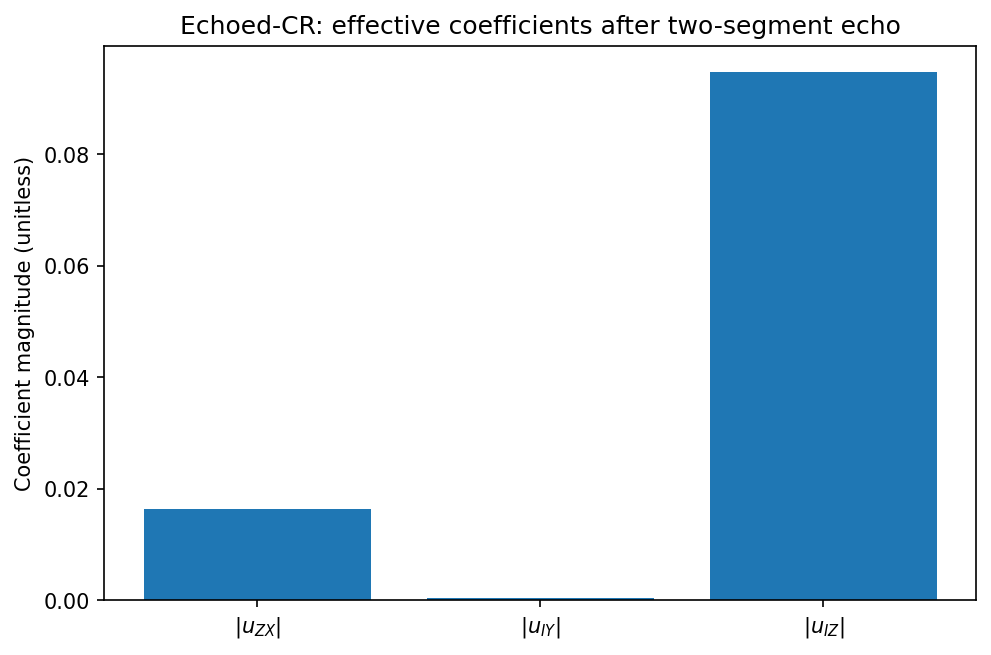

In [ ]:
#@title Echoed-CR demonstration (two-segment echo, Eqs. 28a–d in PRA 2020)

import math
import numpy as np
import matplotlib.pyplot as plt

def omega_echo_coeffs(zx_mhz: float, ix_mhz: float, iz_mhz: float, zz_mhz: float, tau_ns: float):
    """Return (u_ii, u_iy, u_iz, u_zx) after a +Ω / Xπ / −Ω echo; MHz→rad/ns inside."""
    conv = 2.0 * math.pi / 1000.0
    zx, ix, iz, zz = zx_mhz*conv, ix_mhz*conv, iz_mhz*conv, zz_mhz*conv
    w_plus  = math.sqrt((zx + ix)**2 + (iz + zz)**2)
    w_minus = math.sqrt((zx - ix)**2 + (iz - zz)**2)
    c_plus, s_plus = math.cos(0.5*w_plus*tau_ns), math.sin(0.5*w_plus*tau_ns)
    c_minus, s_minus = math.cos(0.5*w_minus*tau_ns), math.sin(0.5*w_minus*tau_ns)
    denom = (w_plus*w_minus + 1e-30)
    u_ii = c_plus*c_minus + ((ix**2 - iz**2 - zx**2 + zz**2)/denom)*s_plus*s_minus
    u_iy = 2j*(zx*zz - ix*iz)/denom * s_plus*s_minus
    u_iz = 1j*((zz - iz)/(w_minus + 1e-30))*c_plus*s_minus - 1j*((zz + iz)/(w_plus + 1e-30))*s_plus*c_minus
    u_zx = 1j*((ix - zx)/(w_minus + 1e-30))*c_plus*s_minus - 1j*((ix + zx)/(w_plus + 1e-30))*s_plus*c_minus
    return u_ii, u_iy, u_iz, u_zx

# Representative point near Region III speed-up:
f_c, f_t = 5114.0, 4914.0
alpha_c = -330.0
J, Omega = 3.8, 30.0
delta0 = f_c - f_t

def omega_zx_mhz(delta_ct, J, Omega, alpha_c):
    return J*Omega*(1.0/(delta_ct + alpha_c) - 1.0/max(delta_ct, 1e-12))

w_zx = omega_zx_mhz(delta0, J, Omega, alpha_c)
w_ix, w_iz, w_zz = 1.0, 10.0, 0.1   # illustrative single-qubit terms / static ZZ
tau_ns = 100.0

u_ii, u_iy, u_iz, u_zx = omega_echo_coeffs(w_zx, w_ix, w_iz, w_zz, tau_ns)

plt.figure(figsize=(7.5, 4.8), dpi=150)
labels = [r'$|u_{ZX}|$', r'$|u_{IY}|$', r'$|u_{IZ}|$']
vals = [abs(u_zx), abs(u_iy), abs(u_iz)]
x = np.arange(len(labels))
plt.bar(x, vals)
plt.xticks(x, labels)
plt.ylabel('Coefficient magnitude (unitless)')
plt.title('Echoed-CR: effective coefficients after two-segment echo')
plt.show()


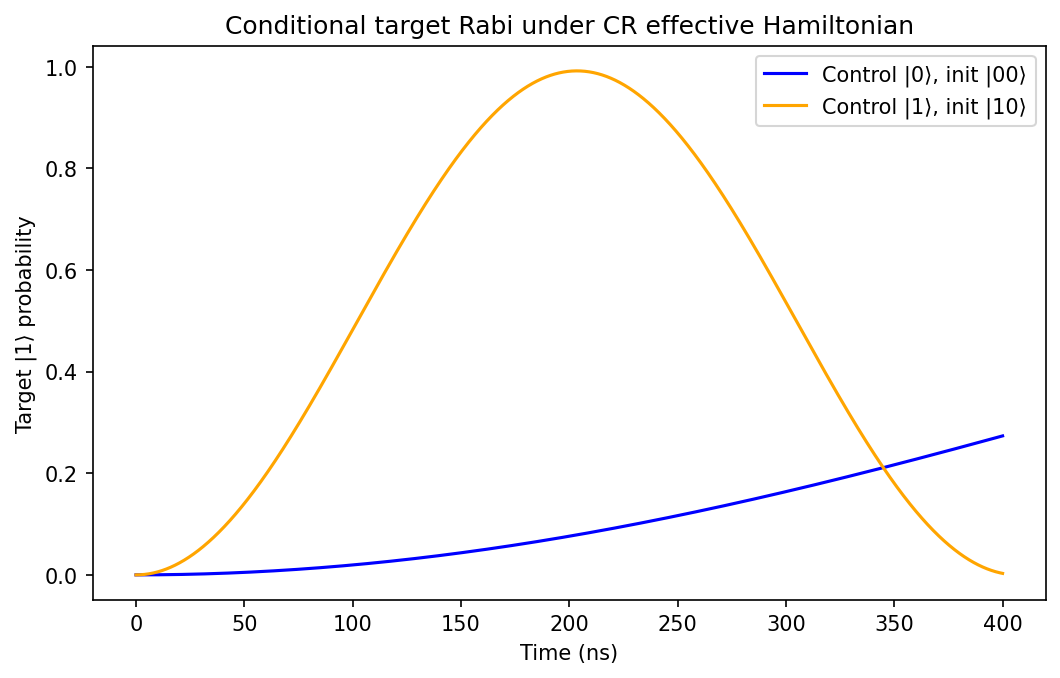

In [ ]:
#@title Conditional target Rabi under CR effective Hamiltonian (self-contained)
# No SciPy needed; we diagonalize once and propagate.
from __future__ import annotations
from dataclasses import dataclass
import math
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Control knobs (MHz unless noted)
# -----------------------------
@dataclass
class RabiKnobs:
    f_c: float = 5114.0          # control frequency
    f_t: float = 4914.0          # target frequency
    alpha_c: float = -330.0      # control anharmonicity
    alpha_t: float = -330.0      # target anharmonicity
    J: float = 3.8               # exchange coupling
    Omega: float = 30.0          # CR drive amplitude on control

    # Residuals (typical orders, tweak for your device)
    wIX_mhz: float = 1.0         # IX (drive crosstalk on target)
    wIZ_khz: float = 20.0        # IZ (AC Stark on target)
    wZI_mhz: float = 10.0        # ZI (AC Stark on control)
    wZZ_khz: float = 100.0       # ZZ (static coupling residual)

    # Time axis
    t_end_ns: float = 400.0
    n_steps: int = 2001

K = RabiKnobs()

# -----------------------------
# Helpers and literature-rate formulas
# -----------------------------
def _safe_div(a: float, b: float, eps: float = 1e-12) -> float:
    return a / (b if abs(b) >= eps else np.sign(b) * eps)

def hz_to_rad_per_ns(hz: float) -> float:
    return 2.0 * math.pi * hz * 1e-9

def mhz_to_rad_per_ns(mhz: float) -> float:
    return hz_to_rad_per_ns(mhz * 1e6)

def khz_to_rad_per_ns(khz: float) -> float:
    return hz_to_rad_per_ns(khz * 1e3)

# Leading-order CR analytics (weak drive, effective model)
# ω_ZX ≈ J Ω [1/(Δ+α_c) − 1/Δ],   ω_ZZ ≈ J^2 [1/(Δ−α_t) − 1/(Δ+α_c)]
def omega_zx_mhz(delta_ct: float, J: float, Omega: float, alpha_c: float) -> float:
    return J * Omega * (_safe_div(1.0, delta_ct + alpha_c) - _safe_div(1.0, delta_ct))

def omega_zz_mhz(delta_ct: float, J: float, alpha_c: float, alpha_t: float) -> float:
    return (J ** 2) * (_safe_div(1.0, delta_ct - alpha_t) - _safe_div(1.0, delta_ct + alpha_c))

# -----------------------------
# Build H_eff (4×4) in rad/ns
# -----------------------------
I2 = np.eye(2)
X = np.array([[0.0, 1.0],
              [1.0, 0.0]])
Z = np.array([[1.0, 0.0],
              [0.0, -1.0]])

def kron2(a, b): return np.kron(a, b)

def build_heff_radns(K: RabiKnobs) -> np.ndarray:
    Δ = K.f_c - K.f_t
    w_zx = mhz_to_rad_per_ns(omega_zx_mhz(Δ, K.J, K.Omega, K.alpha_c))
    w_zz = mhz_to_rad_per_ns(omega_zz_mhz(Δ, K.J, K.alpha_c, K.alpha_t)) + khz_to_rad_per_ns(K.wZZ_khz)
    w_ix = mhz_to_rad_per_ns(K.wIX_mhz)
    w_iz = khz_to_rad_per_ns(K.wIZ_khz)
    w_zi = mhz_to_rad_per_ns(K.wZI_mhz)
    return ((w_ix/2.0) * kron2(I2, X) +
            (w_iz/2.0) * kron2(I2, Z) +
            (w_zi/2.0) * kron2(Z,  I2) +
            (w_zx/2.0) * kron2(Z,  X) +
            (w_zz/2.0) * kron2(Z,  Z))

# -----------------------------
# Time evolution via diagonalization
# -----------------------------
def evolve_state_constH(H: np.ndarray, psi0: np.ndarray, t_ns: np.ndarray) -> np.ndarray:
    E, V = np.linalg.eigh(H)
    Vinv = V.conj().T
    amps0 = Vinv @ psi0
    out = np.empty((psi0.size, t_ns.size), dtype=complex)
    for k, t in enumerate(t_ns):
        out[:, k] = V @ (np.exp(-1j * E * t) * amps0)
    return out

# Basis |00>, |01>, |10>, |11>
e00 = np.array([1,0,0,0], dtype=complex)
e01 = np.array([0,1,0,0], dtype=complex)
e10 = np.array([0,0,1,0], dtype=complex)
e11 = np.array([0,0,0,1], dtype=complex)

# -----------------------------
# Conditional Rabi simulation
# -----------------------------
H = build_heff_radns(K)
t_ns = np.linspace(0.0, K.t_end_ns, K.n_steps)

# Prepare control in |0> (|00>) vs |1> (|10>), target initially |0>
ψ_c0 = evolve_state_constH(H, e00, t_ns)
ψ_c1 = evolve_state_constH(H, e10, t_ns)

# Target |1> probability = P(|01>) + P(|11>)
p_t1_c0 = np.abs(e01.conj() @ ψ_c0)**2 + np.abs(e11.conj() @ ψ_c0)**2
p_t1_c1 = np.abs(e01.conj() @ ψ_c1)**2 + np.abs(e11.conj() @ ψ_c1)**2

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8.2, 4.8), dpi=150)
plt.plot(t_ns, p_t1_c0, label='Control |0⟩, init |00⟩', color='blue')
plt.plot(t_ns, p_t1_c1, label='Control |1⟩, init |10⟩', color='orange')
plt.xlabel('Time (ns)')
plt.ylabel('Target |1⟩ probability')
plt.title('Conditional target Rabi under CR effective Hamiltonian')
plt.legend()
plt.show()


## Cross-Resonance (CR) Gate

| # | Figure | What to notice |
|---:|---|---|
| 1 | $\omega_{ZX}$ vs $\Delta_{ct}$ (slice at fixed $\Omega$) | Entangling-rate sign flips at poles; magnitude peaks between poles; roughly linear in drive amplitude $\Omega$. |
| 2 | $\omega_{ZZ}$ vs $\Delta_{ct}$ | Static $ZZ$ varies strongly near poles; lowest between poles; independent of $\Omega$ at leading order. |
| 3 | $\lvert \omega_{ZX}/\omega_{ZZ}\rvert$ vs $\Delta_{ct}$ | Heuristic **speed-vs-static** figure; tall regions mark friendlier operating points (away from poles). |
| 4 | $\omega_{ZX}(\Delta_{ct}, \Omega)$ heatmap | Linear growth with $\Omega$; detuning structure set by anharmonicities; region boundaries visible as sharp changes. |
| 5 | $\lvert \omega_{ZX}/\omega_{ZZ}\rvert(\Delta_{ct}, \Omega)$ heatmap | Bright bands away from poles suggest high entangling-rate with low static $ZZ$ (good for echoed-CR). |
| 6 | Echoed-CR coefficients (two-segment echo) | Echo preserves odd-in-$\Omega$ $ZX$ and suppresses even-in-$\Omega$ terms ($IZ$, $ZZ$) to first order. |
| 7 | Conditional target Rabi (control $\lvert0\rangle$ vs $\lvert1\rangle$) | Target oscillation frequency/phase depends on control state due to the $ZX$ term (and any residual $IX$). |

---

### References

- The Quantum Aviary — *How the Cross-Resonance Gate Works* (overview of $ZX$, echo, and intuition)  
  https://thequantumaviary.blogspot.com/2021/07/how-cross-resonance-gate-works.html

- Malekakhlagh, Magesan & McKay — *First-principles analysis of cross-resonance gate operation*, **Phys. Rev. A** 102, 042605 (2020)  
  https://link.aps.org/doi/10.1103/PhysRevA.102.042605

- Magesan & Gambetta — *Effective Hamiltonian models of the cross-resonance gate*, **Phys. Rev. A** 101, 052308 (2020)  
  https://link.aps.org/doi/10.1103/PhysRevA.101.052308
